In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np


In [2]:
class RBM(nn.Module):
    def __init__(self, visible_dim, hidden_dim, k=1):
        super(RBM, self).__init__()
        self.visible_dim = visible_dim
        self.hidden_dim = hidden_dim
        self.k = k
        self.W = nn.Parameter(torch.randn(visible_dim, hidden_dim) * 0.01)
        self.visible_bias = nn.Parameter(torch.zeros(visible_dim))
        self.hidden_bias = nn.Parameter(torch.zeros(hidden_dim))

    def sample_hidden(self, visible_probs):
        hidden_probs = torch.sigmoid(torch.matmul(visible_probs, self.W) + self.hidden_bias)
        return torch.bernoulli(hidden_probs)

    def sample_visible(self, hidden_probs):
        visible_probs = torch.sigmoid(torch.matmul(hidden_probs, self.W.t()) + self.visible_bias)
        return torch.bernoulli(visible_probs)

    def contrastive_divergence(self, visible):
        v0 = visible
        h0 = self.sample_hidden(v0)
        v_k = v0.clone()
        for _ in range(self.k):
            h_k = self.sample_hidden(v_k)
            v_k = self.sample_visible(h_k)
        return v0, h0, v_k

    def forward(self, visible):
        v0, h0, v_k = self.contrastive_divergence(visible)
        positive_association = torch.matmul(v0.t(), h0)
        negative_association = torch.matmul(v_k.t(), self.sample_hidden(v_k))
        return positive_association - negative_association


In [3]:
from torchvision import datasets, transforms

def bernoulli(x):
    return torch.bernoulli(x)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(bernoulli)
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=5, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=5, shuffle=False, num_workers=2)


100%|██████████| 9912422/9912422 [00:00<00:00, 82060995.97it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38763422.02it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 19528086.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 12933149.20it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
visible_dim = 28 * 28
hidden_dim = 128
k = 1
learning_rate = 0.01
epochs = 10

rbm = RBM(visible_dim, hidden_dim, k)
optimizer = optim.SGD(rbm.parameters(), lr=learning_rate)

for epoch in range(epochs):
    train_loss = 0
    for i, (data, _) in enumerate(train_loader):
        data = data.view(-1, visible_dim)
        optimizer.zero_grad()
        delta_W = rbm(data)
        loss = -torch.mean(delta_W)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss / (i + 1)}")


Epoch 1/10, Loss: 0.9161937794933717
Epoch 2/10, Loss: 0.9165953301986058
Epoch 3/10, Loss: 0.9162200504293044
Epoch 4/10, Loss: 0.9159228914876779
Epoch 5/10, Loss: 0.9153631527572871
Epoch 6/10, Loss: 0.9154192441453536
Epoch 7/10, Loss: 0.9168450768788655
Epoch 8/10, Loss: 0.9168852233886718
Epoch 9/10, Loss: 0.9151779252936443
Epoch 10/10, Loss: 0.9156410332769156


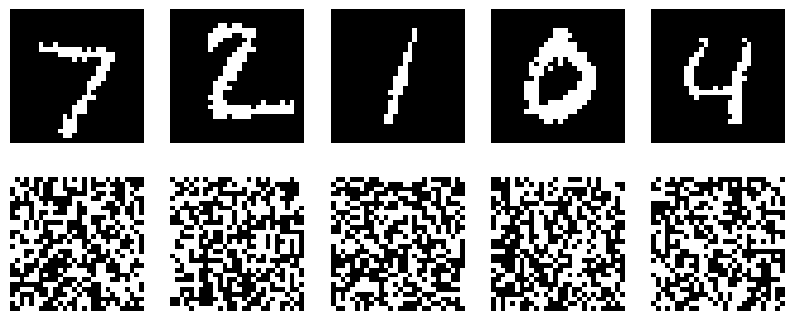

In [5]:
import matplotlib.pyplot as plt

def display_reconstruction(rbm, test_loader, num_images=5):
    _, (test_data, _) = next(enumerate(test_loader))
    test_data = test_data[:num_images].view(-1, visible_dim)
    v0, _, v_k = rbm.contrastive_divergence(test_data)

    fig, axes = plt.subplots(nrows=2, ncols=num_images, figsize=(10, 4))
    for i in range(num_images):
        axes[0, i].imshow(v0[i].view(28, 28).detach().numpy(), cmap='gray')
        axes[1, i].imshow(v_k[i].view(28, 28).detach().numpy(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    plt.show()

display_reconstruction(rbm, test_loader)
